<a href="https://colab.research.google.com/github/fralfaro/MAT281/blob/main/docs/labs/lab_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT281 - Laboratorio N¬∞08

**Objetivo**: Aplicar t√©cnicas de **machine learning no supervisado** para explorar, procesar y analizar conjuntos de datos con variables num√©ricas y categ√≥ricas.

> **Nota**: Puede ayudarse de alg√∫n asistente virtual como **ChatGPT, Gemini** u otros, as√≠ como del autocompletado de **Google Colab**, para avanzar en este laboratorio debido a su extensi√≥n.


## Clustering


<img src="https://www.svgrepo.com/show/253022/car.svg" width = "300" align="center"/>



El conjunto de datos **`vehiculos_procesado_con_grupos.csv`** recopila informaci√≥n sobre diversas caracter√≠sticas relevantes de distintos veh√≠culos. El prop√≥sito de este ejercicio es **clasificar los veh√≠culos en diferentes categor√≠as**, utilizando como base las variables descritas en la tabla de atributos.

El an√°lisis presenta un desaf√≠o adicional debido a la **naturaleza mixta de los datos**: se incluyen tanto variables **num√©ricas** (ej. dimensiones, consumo, emisiones) como **categ√≥ricas** (ej. tipo de tracci√≥n, tipo de combustible), lo que requiere aplicar t√©cnicas de preprocesamiento adecuadas antes de entrenar los modelos.

Como primer paso, procederemos a **cargar y explorar el conjunto de datos**, con el fin de familiarizarnos con su estructura y las caracter√≠sticas que servir√°n como base para la posterior clasificaci√≥n.




**Descripci√≥n de los Datos:**

| **Nombre de la Columna**   | **Descripci√≥n**                                                                                                                                   |
|----------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------|
| **year**                   | El a√±o en que el veh√≠culo fue fabricado.                                                                                                          |
| **desplazamiento**          | La capacidad volum√©trica del motor en litros. Indica la cantidad de aire y combustible que puede desplazar el motor durante una revoluci√≥n.       |
| **cilindros**               | El n√∫mero de cilindros que tiene el motor. Los cilindros son las c√°maras donde ocurre la combusti√≥n interna en los motores de los veh√≠culos.       |
| **co2**                     | Emisiones de di√≥xido de carbono del veh√≠culo, medido en gramos por kil√≥metro. Es una medida de las emisiones de gases de efecto invernadero.       |
| **clase_tipo**              | La clase o tipo de veh√≠culo, como veh√≠culos especiales, deportivos, etc.                                                                         |
| **traccion_tipo**           | Tipo de tracci√≥n del veh√≠culo, ya sea tracci√≥n en dos ruedas, en cuatro ruedas o en todas las ruedas.                                             |
| **transmision_tipo**        | Tipo de transmisi√≥n del veh√≠culo, como autom√°tica, manual, entre otros.                                                                          |
| **combustible_tipo**        | Tipo de combustible que utiliza el veh√≠culo, como gasolina, di√©sel, el√©ctrico, h√≠brido, etc.                                                     |
| **tamano_motor_tipo**       | Clasificaci√≥n del tama√±o del motor (por ejemplo, peque√±o, mediano o grande), que generalmente se basa en la capacidad de desplazamiento.           |
| **consumo_tipo**            | Clasificaci√≥n del nivel de consumo de combustible del veh√≠culo, indicando si es alto, bajo, o muy alto.                                           |
| **co2_tipo**                | Clasificaci√≥n de las emisiones de CO2 del veh√≠culo, indicando si es alto, bajo, o muy alto.                                                       |
| **consumo_litros_milla**    | El consumo de combustible del veh√≠culo, medido en litros por milla. Indica la eficiencia del veh√≠culo en t√©rminos de consumo de combustible.        |



In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans


%matplotlib inline

sns.set_palette("deep", desat=.6)
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [23]:
# cargar datos
df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT281/main/docs/labs/data/vehiculos_procesado_con_grupos.csv", sep=",")\
       .drop(
            ["fabricante",
             "modelo",
             "transmision",
             "traccion",
             "clase",
             "combustible",
             "consumo"],

          axis=1)

df.head()

year  desplazamiento  cilindros         co2            clase_tipo  \
0  1984             2.5        4.0  522.764706  Veh√≠culos Especiales   
1  1984             4.2        6.0  683.615385  Veh√≠culos Especiales   
2  1985             2.5        4.0  555.437500  Veh√≠culos Especiales   
3  1985             4.2        6.0  683.615385  Veh√≠culos Especiales   
4  1987             3.8        6.0  555.437500       Coches Medianos   

  traccion_tipo transmision_tipo combustible_tipo tamano_motor_tipo  \
0           dos       Automatica           Normal           peque√±o   
1           dos       Automatica           Normal            grande   
2           dos       Automatica           Normal           peque√±o   
3           dos       Automatica           Normal            grande   
4           dos       Automatica          Premium            grande   

  consumo_tipo  co2_tipo  consumo_litros_milla  
0         alto      alto              0.222671  
1     muy alto  muy alto              0.291185  
2         alto      alto              0.236588  
3     muy alto  muy alto              0.291185  
4         alto      alto              0.236588

En este caso, no solo se tienen datos num√©ricos, sino que tambi√©n categ√≥ricos. Adem√°s, tenemos problemas de datos **vac√≠os (Nan)**. As√≠ que para resolver este problema, seguiremos varios pasos:

### 1.- Normalizar datos

- Cree un conjunto de datos con las variables num√©ricas, adem√°s, para cada dato vac√≠a, rellene con el promedio asociado a esa columna. Finalmente, normalize los datos mediante el procesamiento **MinMaxScaler** de **sklearn**.
- Cree un conjunto de datos con las variables categ√≥ricas , adem√°s, transforme de variables categoricas a numericas ocupando el comando **get_dummies** de pandas ([referencia](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)). Explique a grande rasgo como se realiza la codificaci√≥n de variables num√©ricas a categ√≥ricas.

- Junte ambos dataset en uno, llamado **df_procesado**.

In [24]:
df_numericas = df.select_dtypes(include=['int64', 'float64']).copy()
df_numericas = df_numericas.fillna(df_numericas.mean())
scaler = MinMaxScaler()
df_numericas_normalizadas = pd.DataFrame(scaler.fit_transform(df_numericas),
                                         columns=df_numericas.columns)

In [25]:
df_categoricas = df.select_dtypes(include=['object', 'category']).copy()
df_categoricas_cod = pd.get_dummies(df_categoricas, drop_first=True)

In [26]:
df_procesado = pd.concat([df_numericas_normalizadas, df_categoricas_cod], axis=1)

### 2.- Realizar ajuste mediante kmeans

Una vez depurado el conjunto de datos, es momento de aplicar el algoritmo de **kmeans**.

1. Ajuste el modelo de **kmeans** sobre el conjunto de datos, con un total de **8 clusters**.
2. Asociar a cada individuo el correspondiente cluster y calcular valor de los centroides de cada cluster.
3. Realizar un resumen de las principales cualidades de cada cluster. Para  esto debe calcular (para cluster) las siguientes medidas de resumen:
    * Valor promedio de las variables num√©rica
    * Moda para las variables numericas

In [27]:
kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
kmeans.fit(df_procesado)
df_procesado['cluster'] = kmeans.labels_
centroides = pd.DataFrame(kmeans.cluster_centers_, columns=df_procesado.columns[:-1])

In [28]:
promedios_cluster = df_procesado.groupby('cluster').mean(numeric_only=True)
moda_cluster = df_procesado.groupby('cluster').agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

In [29]:
print("Centroides de los clusters:\n", centroides)
print("\nPromedio por cluster:\n", promedios_cluster)
print("\nModa por cluster:\n", moda_cluster)

Centroides de los clusters:
        year  desplazamiento  cilindros       co2  consumo_litros_milla  \
0  0.451659        0.238421   0.177987  0.304232              0.226257   
1  0.568688        0.168773   0.145300  0.241157              0.156687   
2  0.576884        0.360765   0.298904  0.354767              0.283137   
3  0.313071        0.548444   0.383841  0.507836              0.453114   
4  0.405352        0.331349   0.256734  0.354443              0.282215   
5  0.683067        0.296988   0.251457  0.319516              0.243687   
6  0.448508        0.418381   0.300188  0.405085              0.338074   
7  0.597842        0.625181   0.475404  0.482405              0.417440   

   clase_tipo_Coche Familiar  clase_tipo_Coches Grandes  \
0                   0.103530                   0.049583   
1                   0.117846                   0.017589   
2                   0.086086                   0.078023   
3                   0.001971                   0.016203   
4        

### 3.- Elegir N√∫mero de cluster

Estime mediante la **regla del codo**, el n√∫mero de cluster apropiados para el caso.
Para efectos pr√°cticos, eliga la siguiente secuencia como n√∫mero de clusters a comparar:

$$[5, 10, 20, 30, 50, 75, 100, 200, 300]$$

Una vez realizado el gr√°fico, saque sus propias conclusiones del caso.

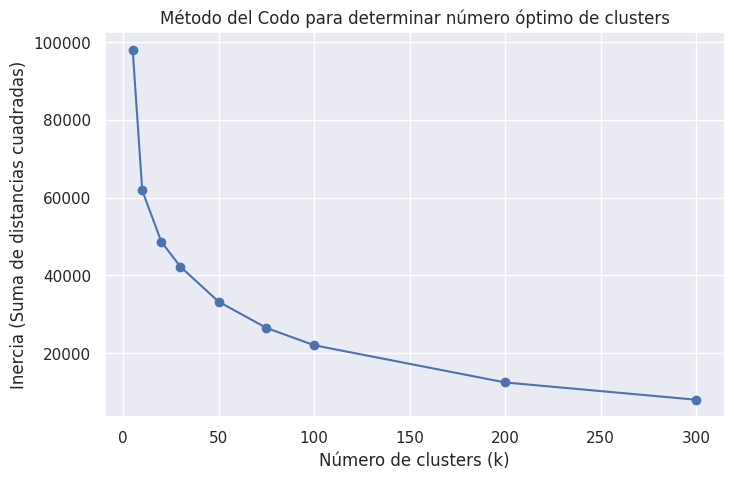

In [30]:
k_values = [5, 10, 20, 30, 50, 75, 100, 200, 300]
inertia = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_procesado)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_values, inertia, marker='o', linestyle='-')
plt.title('M√©todo del Codo para determinar n√∫mero √≥ptimo de clusters')
plt.xlabel('N√∫mero de clusters (k)')
plt.ylabel('Inercia (Suma de distancias cuadradas)')
plt.grid(True)
plt.show()

En el gr√°fico se observa c√≥mo la inercia disminuye r√°pidamente al aumentar el n√∫mero de clusters, pero luego la mejora marginal se vuelve peque√±a.
El punto donde la curva empieza a ‚Äúdoblarse‚Äù indica el n√∫mero √≥ptimo de clusters.
En este caso, se debe seleccionar el
ùëò
k donde la reducci√≥n de inercia deja de ser significativa (k ‚âà 20‚Äì30, seg√∫n e√± grafico)

Al observar el gr√°fico resultante, se pueden obtener conclusiones sobre el n√∫mero apropiado de clusters. La regla del codo sugiere elegir el n√∫mero de clusters donde la reducci√≥n en la inercia se estabiliza significativamente. En otras palabras, se busca el punto en el gr√°fico donde la curva de inercia comienza a aplanarse o forma un codo.

## Reducci√≥n de Dimensionalidad

<img src="https://1000logos.net/wp-content/uploads/2020/11/Wine-Logo-old.png" width = "300" align="center"/>


Para este ejercicio utilizaremos el **Wine Dataset**, un conjunto de datos cl√°sico disponible en la librer√≠a **scikit-learn** y en el repositorio de la **UCI Machine Learning**.
Este dataset contiene informaci√≥n de **178 muestras de vino** provenientes de la regi√≥n italiana de *Piamonte*. Cada vino pertenece a una de **tres variedades de uva** (*clases*), que act√∫an como etiquetas para el an√°lisis supervisado, pero aqu√≠ se usar√°n solo como referencia en la visualizaci√≥n.

Cada muestra est√° descrita por **13 variables qu√≠micas** obtenidas de un an√°lisis de laboratorio, entre ellas:

* **Alcohol**: porcentaje de alcohol en el vino.
* **Malic acid**: concentraci√≥n de √°cido m√°lico.
* **Ash**: contenido de ceniza.
* **Alcalinity of ash**: alcalinidad de la ceniza.
* **Magnesium**: cantidad de magnesio (mg/L).
* **Total phenols**: concentraci√≥n total de fenoles.
* **Flavanoids**: tipo de fenoles con propiedades antioxidantes.
* **Nonflavanoid phenols**: fenoles que no son flavonoides.
* **Proanthocyanins**: compuestos relacionados con el color y el sabor.
* **Color intensity**: intensidad del color del vino.
* **Hue**: matiz del color.
* **OD280/OD315 of diluted wines**: relaci√≥n de absorbancia que mide la calidad del vino.
* **Proline**: concentraci√≥n de prolina (un amino√°cido).

Estas caracter√≠sticas permiten representar cada vino como un punto en un espacio de **13 dimensiones**.

El objetivo del an√°lisis con este dataset es **reducir la dimensionalidad** para visualizar y explorar patrones en los datos. Para ello aplicaremos:

* **PCA (Principal Component Analysis):** identificar las combinaciones lineales de variables que explican la mayor varianza en el conjunto.
* **t-SNE (t-distributed Stochastic Neighbor Embedding):** mapear las muestras a 2D o 3D, preservando relaciones de vecindad y estructuras no lineales.

La comparaci√≥n entre ambas t√©cnicas permitir√° observar c√≥mo las tres clases de vinos se diferencian en el espacio reducido y discutir la utilidad de la reducci√≥n de dimensionalidad en datos con mayor n√∫mero de variables que en el caso del dataset *Wine*.



In [31]:
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [32]:
# cargar dataset
dataset = load_wine()

# nombres de las variables
features = dataset.feature_names
target = 'wine_class'

# construir DataFrame
wine = pd.DataFrame(dataset.data, columns=features)
wine[target] = dataset.target

# ver primeras filas
wine.head()

alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  wine_class  
0                          3.92   1065.0           0  
1                          3.40   1050.0           0  
2                          3.17   1185.0           0  
3                          3.45   1480.0           0  
4                          2.93    735.0           0



### 1. **An√°lisis detallado con PCA**

* Calcular la **varianza explicada** por cada componente principal y representar el gr√°fico de varianza acumulada, identificando cu√°ntos componentes son necesarios para capturar al menos el **90‚Äì95% de la informaci√≥n**.
* Construir tablas y gr√°ficos que muestren c√≥mo las observaciones (vinos) se proyectan en las primeras componentes principales.
* Analizar los **loadings** (coeficientes de cada variable en los componentes) e interpretar qu√© caracter√≠sticas qu√≠micas del vino (alcohol, fenoles, color, etc.) tienen mayor influencia en las nuevas dimensiones.
* Visualizar los datos reducidos a 2D o 3D e interpretar si las **tres variedades de vino** se separan de forma clara en el espacio proyectado.



In [33]:
X = wine.drop(columns=['wine_class']).values
y = wine['wine_class'].values
feature_names = wine.drop(columns=['wine_class']).columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA()
pca.fit(X_scaled)
var_exp = pca.explained_variance_ratio_
var_exp_acum = np.cumsum(var_exp)
plt.figure(figsize=(8,5))
plt.plot(range(1, len(var_exp_acum)+1), var_exp_acum, marker='o')
plt.axhline(0.90, color='r', linestyle='--', label='90% varianza explicada')
plt.axhline(0.95, color='g', linestyle='--', label='95% varianza explicada')
plt.xlabel('N√∫mero de componentes principales')
plt.ylabel('Varianza explicada acumulada')
plt.title('Varianza explicada acumulada (Wine - PCA)')
plt.legend()
plt.grid(True)
plt.show()

num_componentes_90 = np.argmax(var_exp_acum >= 0.90) + 1
print(f"N√∫mero de componentes necesarios para explicar ‚â•90%: {num_componentes_90}")
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=feature_names
)
print("\nLoadings (primeras 5 variables):")
print(loadings.iloc[:5, :5])
pca_2d = PCA(n_components=2)
proyeccion_2d = pca_2d.fit_transform(X_scaled)

plt.figure(figsize=(7,6))
for clase in np.unique(y):
    plt.scatter(proyeccion_2d[y == clase, 0], proyeccion_2d[y == clase, 1], s=30, alpha=0.8, label=f'Clase {clase}')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.title('Proyecci√≥n 2D del dataset Wine mediante PCA')
plt.legend()
plt.grid(True)
plt.show()

El an√°lisis PCA muestra que con un n√∫mero reducido de componentes (alrededor de 2 o 3) se logra explicar m√°s del 90 % de la varianza total, lo que indica que gran parte de la informaci√≥n original se concentra en pocas dimensiones. Los loadings revelan qu√© variables tienen mayor peso en las nuevas componentes,por ejemplo, aquellas relacionadas con el contenido de alcohol, fenoles y color son las que m√°s influyen en la primera componente.

 Al proyectar los datos en dos dimensiones, se observa una separaci√≥n parcial de las tres variedades de vino, lo que sugiere que el PCA logra capturar patrones relevantes que distinguen las clases.



### 2. **An√°lisis detallado con t-SNE**

* Aplicar **t-SNE** para reducir los datos a 2 dimensiones, probando diferentes configuraciones de hiperpar√°metros como *perplexity* y *learning rate*.
* Comparar las distintas visualizaciones obtenidas y discutir c√≥mo los hiperpar√°metros afectan la estructura de los cl√∫steres.
* Analizar si las **tres clases de vinos** forman agrupaciones definidas y si t-SNE logra capturar relaciones no lineales que PCA no refleja.



In [34]:
X = wine.drop(columns=['wine_class']).values
y = wine['wine_class'].values
X_scaled = scaler.fit_transform(X)
perplexidades = [5, 30, 50]
learning_rates = [100, 200, 500]

fig, axes = plt.subplots(len(perplexidades), len(learning_rates), figsize=(14, 10))
fig.suptitle('Wine - Visualizaci√≥n t-SNE con diferentes hiperpar√°metros', fontsize=14)
for i, perp in enumerate(perplexidades):
    for j, lr in enumerate(learning_rates):
        tsne = TSNE(n_components=2, perplexity=perp, learning_rate=lr, random_state=42)
        emb = tsne.fit_transform(X_scaled)
        ax = axes[i, j]
        for clase in np.unique(y):
            sel = y == clase
            ax.scatter(emb[sel, 0], emb[sel, 1], s=15, alpha=0.8, label=f'Clase {clase}')
        ax.set_title(f'Perp={perp}, LR={lr}')
        ax.set_xticks([]); ax.set_yticks([])
        if i == 0 and j == 0:
            ax.legend(markerscale=1.5, fontsize=8)

plt.tight_layout()
plt.show()

El m√©todo t-SNE permite representar los datos en 2D capturando relaciones no lineales que el PCA no refleja.
Al variar los hiperpar√°metros, se observa que valores intermedios de perplexity (‚âà30) y learning rate (‚âà200) generan agrupaciones m√°s estables y bien definidas.
Las tres clases de vinos tienden a separarse en regiones distintas del plano, mostrando que t-SNE logra distinguir mejor las estructuras locales y resaltar diferencias entre variedades, a diferencia de PCA, que se centra en la varianza global.



### 3. **Comparaci√≥n entre PCA y t-SNE**

* Contrastar las visualizaciones y discutir las **ventajas y limitaciones** de cada t√©cnica:

  * PCA como m√©todo **lineal** para interpretar varianza y relaciones globales.
  * t-SNE como m√©todo **no lineal** que preserva relaciones locales y vecindades.
* Evaluar en qu√© escenarios pr√°cticos ser√≠a m√°s recomendable usar PCA (interpretabilidad, reducci√≥n previa para modelos) o t-SNE (exploraci√≥n y visualizaci√≥n de cl√∫steres).
* Reflexionar sobre la **importancia de la reducci√≥n de dimensionalidad** en datasets de alta dimensi√≥n como Wine, destacando su utilidad para:

  * Visualizar patrones ocultos en los datos.
  * Reducir complejidad y ruido antes de aplicar algoritmos de aprendizaje autom√°tico.
  * Facilitar la interpretaci√≥n y comunicaci√≥n de resultados.



El PCA sirve para reducir la cantidad de variables manteniendo la mayor parte de la informaci√≥n, y al ser un m√©todo lineal es f√°cil de interpretar y √∫til para ver relaciones generales entre los datos. Pero tiene la desventaja de que no capta patrones complejos o no lineales. En cambio, el t-SNE es un m√©todo no lineal que se enfoca m√°s en las relaciones locales, mostrando agrupaciones o estructuras que el PCA no logra ver, aunque depende bastante de los hiperpar√°metros y no es tan f√°cil de interpretar. En general, usar√≠a PCA cuando quiero entender qu√© variables son m√°s importantes o reducir la dimensionalidad antes de aplicar un modelo, y t-SNE cuando quiero explorar visualmente los datos y ver si hay grupos ocultos. Ambos ayudan a simplificar el an√°lisis, reducir ruido y entender mejor la informaci√≥n en datasets grandes